**Задание**

Сделайте генератор лиц аниме на основе датасета https://www.kaggle.com/datasets/soumikrakshit/anime-faces

In [ ]:
import os
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

import random
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np

In [ ]:
!rm -R /content/sample_data/anime/.ipynb_checkpoints
!ls /content/sample_data/anime/ -a   #to make sure that the deletion has occurred

rm: cannot remove '/content/sample_data/anime/.ipynb_checkpoints': No such file or directory
.  ..  data


In [ ]:
data_dir = '/content/sample_data/anime'

In [ ]:
# load few images
print(os.listdir(data_dir))
print(len(os.listdir(data_dir+'/data')))
os.listdir(data_dir+'/data')[0:10]

['data']
1642


['661.png',
 '151.png',
 '381.png',
 '1278.png',
 '957.png',
 '1231.png',
 '1161.png',
 '516.png',
 '1012.png',
 '244.png']

In [ ]:
image_size = 64
batch_size = 256
stats = (0.5,0.5,0.5), (0.5,0.5,0.5)

In [ ]:
# load the images and transform them with resize, crop and normalization
train_ds = ImageFolder(data_dir, transform = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

# load the images in batch
train_loader = DataLoader(train_ds, batch_size, shuffle = True,
                         num_workers = 2, pin_memory = False)

In [ ]:
# denormalize the images to in order to display them
stats[1][0]
def denorm(img_tensors):
    return img_tensors*stats[1][0] + stats[0][0]

In [ ]:
# define a helper functio to display a image and dispaly a batch of images
def show_images(images, nmax=64):
    plt.subplots(figsize=(10,10))
    plt.xticks([]), plt.yticks([])
    plt.imshow(make_grid(denorm(images.detach()[:nmax]), nrow = 8).permute(1,2,0))
    
def show_batch(dl, nmax =64):
    for images, _ in dl:
        show_images(images, nmax)
        break

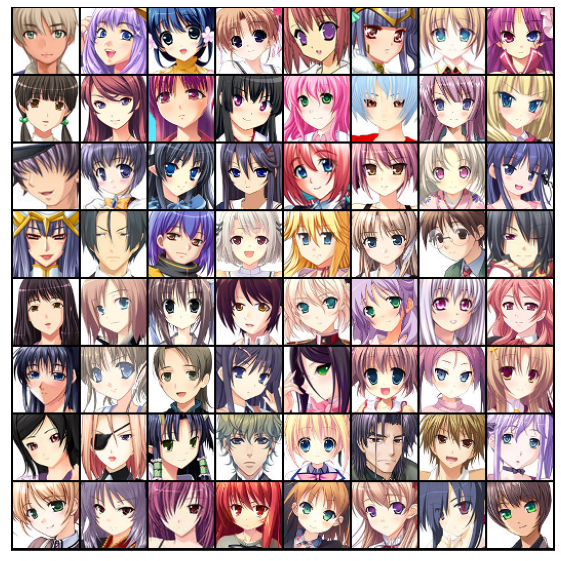

In [ ]:
show_batch(train_loader)

In [ ]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = torch.nn.functional.leaky_relu(self.fc1(x), 0.2)
        x = torch.nn.functional.leaky_relu(self.fc2(x), 0.2)
        x = torch.nn.functional.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = torch.nn.functional.leaky_relu(self.fc1(x), 0.2)
        x = torch.nn.functional.dropout(x, 0.3)
        x = torch.nn.functional.leaky_relu(self.fc2(x), 0.2)
        x = torch.nn.functional.dropout(x, 0.3)
        x = torch.nn.functional.leaky_relu(self.fc3(x), 0.2)
        x = torch.nn.functional.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [ ]:
z_dim = 100
anime_dim = 64*64*3

G = Generator(g_input_dim = z_dim, g_output_dim = anime_dim)
D = Discriminator(anime_dim)

In [ ]:
G

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=12288, bias=True)
)

In [ ]:
D

Discriminator(
  (fc1): Linear(in_features=12288, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr, betas=(0.5, 0.999))

In [ ]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real

    x_real, y_real = torch.FloatTensor(x.permute(0, 2, 3, 1)).reshape(batch_size,anime_dim), torch.ones(batch_size, 1)

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on fake
    z = torch.randn(batch_size, z_dim)
    x_fake, y_fake = G(z), torch.zeros(batch_size, 1)

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [ ]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = torch.randn(batch_size, z_dim)
    y = torch.ones(batch_size, 1)

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [ ]:
n_epoch = 150
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []

    for i, (x,_) in enumerate(train_loader,0):

        if len(x) != batch_size:
          continue
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

[1/150]: loss_d: 1.045, loss_g: 1.192
[2/150]: loss_d: 0.657, loss_g: 1.293
[3/150]: loss_d: 0.625, loss_g: 1.416
[4/150]: loss_d: 0.686, loss_g: 1.355
[5/150]: loss_d: 0.835, loss_g: 1.323
[6/150]: loss_d: 1.062, loss_g: 1.328
[7/150]: loss_d: 0.773, loss_g: 1.225
[8/150]: loss_d: 0.931, loss_g: 1.260
[9/150]: loss_d: 0.786, loss_g: 1.325
[10/150]: loss_d: 0.831, loss_g: 1.360
[11/150]: loss_d: 0.948, loss_g: 1.342
[12/150]: loss_d: 0.660, loss_g: 1.329
[13/150]: loss_d: 0.633, loss_g: 1.695
[14/150]: loss_d: 0.978, loss_g: 1.414
[15/150]: loss_d: 0.739, loss_g: 1.404
[16/150]: loss_d: 1.020, loss_g: 1.353
[17/150]: loss_d: 0.854, loss_g: 1.428
[18/150]: loss_d: 0.837, loss_g: 1.538
[19/150]: loss_d: 1.078, loss_g: 1.157
[20/150]: loss_d: 0.796, loss_g: 1.419
[21/150]: loss_d: 1.010, loss_g: 1.460
[22/150]: loss_d: 0.896, loss_g: 1.151
[23/150]: loss_d: 0.808, loss_g: 1.587
[24/150]: loss_d: 0.880, loss_g: 1.520
[25/150]: loss_d: 0.687, loss_g: 1.595
[26/150]: loss_d: 0.932, loss_g: 1

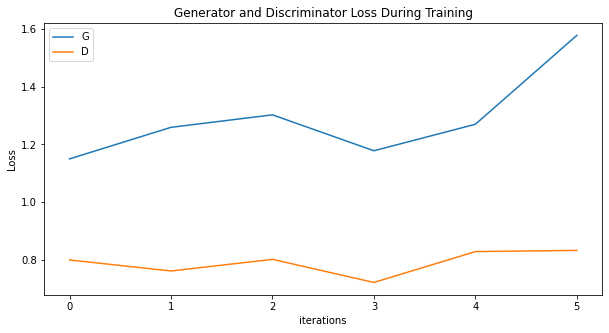

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

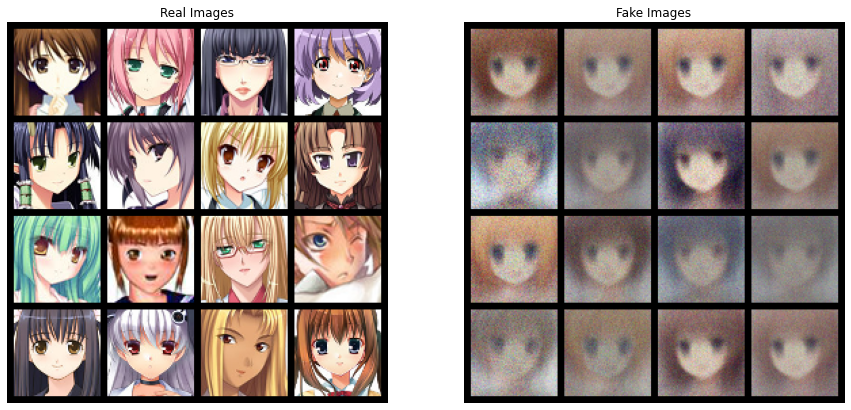

In [ ]:
# Compare outputs
num_img = 16
_nrow = int(num_img/4)
real_batch = next(iter(train_loader))
fake_batch = G(torch.randn(num_img, z_dim)).detach().reshape(num_img,64,64,3).permute(0,3,1,2)   # (N, C, H, W)
# Plot the real images
plt.figure(figsize=(15, 15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(make_grid(real_batch[0][:num_img], padding=5, normalize=True, nrow=_nrow).permute(1, 2, 0))
# Plot the fake images
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(make_grid(fake_batch, padding=5, normalize=True, nrow=_nrow).permute(1, 2, 0));